# Customer and sales insurance data analysis
This project builds a user profile of an interested customer. 
It answers the question: who would be interested in an insurance and why? 
The data provided is a mixture of customer and sales data. 

## Preprocessing

The following questions need to be answered:

- Batch learning or online learning?<br> 
  **Batch learning.**
- Amount of data? Number of attributes? Data quality?<br> 
  **5821 data points, 86 attributes, dataquality:no missing or null values, duplicates yes, no eroneous values, normalisation because of attributes with large absolute ranges needed**
- Class ratio? Balanced or there are rare classes? Is the class ratio representative(for the new fresh data)?<br>
  **In this particular case we aren't doing classification. Rather, we will attempt to cluster data. It isn't possible to inspect a target class for it's balanced numbers.**
- Who has labeled the target data? Will it represent the incoming data?<br>
  **The data is from existing clients, so it should represent the incoming data well.**
- Is the marginal distribution p(x) of the training data equal to the fresh data?<br> 
  **This we cannot know for sure, but we can asume that it will be, as the data is a subset of the data that the insurance works with every day.**
- How recent is the data? Should we account for changing processes over time?<br>
  **N/A. If something changes in the way data collection is made or saved by the insurance, we would have to change the setup.**
- Multiple data sources? How is each source’s credibility, quality and consistency?<br> 
  **Just one source, no way to check.**
- Is there a fixed given data set, or a data collection protocol needs to be developed?<br> 
  **It is a fixed given dataset.**
- Data dependencies: data might contain independent observations, sequences or interdependent data.<br>
  **I explored this with the scatter matrix and the principal component analysis**

Preprocessing actions (see implementations in their respective sections below):

- Solve data conflicts (things like different unit measurements) ✅ **(not necessary)**
- Check and remove duplicates ✅
- Transform categorical data to numeric if necessary ✅ **(already done)**
- Check for large absolute ranges of the attributes - if they are present perform feature normalisation ✅
- Feature construction: should some features be merged or mapped to allow more complex decisions? ❌
- Handle missing values ✅
- Handle erroneous values ✅
- Perform feature selection if necessary for dimensionality reduction ✅

In [1]:
import pandas as pd

df = pd.read_csv("data/caravan.train", delimiter="\t")
df.columns = range(1, 87)
df

,1,2,3,4,5,6,7,8,9,10,...,77,78,79,80,81,82,83,84,85,86
0,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
2,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
3,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
4,23,1,2,1,5,0,5,0,5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,0
5817,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
5818,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,1
5819,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


### Creating dictionaries with the data descriptions and labels to use for better understand and visualisaion

In [2]:
from collections import defaultdict

data = []

#Read the data infomation from the file
with open("data/caravan.info", "r", encoding="unicode_escape") as f:
    lines = [line.split() for line in f.readlines()]
    for i, line in enumerate(lines): 
        if line == [] and lines[i-1] == []:
            data.append(lines[2:i-1]) if not data else data.append(lines[checkpoint:i-1])
            checkpoint = i+1    

#Package data
def return_value_dict(keys, values):
    d = defaultdict(dict)
    for i, v in enumerate(values, start=1):
        for j, k in enumerate(keys):
            d[i].update({k:v[j+1]}) if j==0 else d[i].update({k:" ".join(v[2:])})
    return d

#Create comprehensive dicts to use with visualisation
add_keys = [data[1][2][1]]

data_dict = return_value_dict(data[0][0][1:3], data[0][2:])
L0 = return_value_dict(add_keys, data[1][3:])
L1 = return_value_dict(add_keys, data[2][2:])
L3 = return_value_dict(add_keys, data[3][2:])

In [3]:
df.columns = [data_dict.get(i, {}).get('Name') for i in range (1, 87)]

df.head(5)

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
2,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
3,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
4,23,1,2,1,5,0,5,0,5,0,...,0,0,0,0,0,0,0,0,0,0


### Missing values 

In [4]:
df.isnull().values.any()
#There aren't any missing values in the data

False

### Duplicates

In [5]:
df.duplicated().value_counts()
#There seem to be 602 duplicated items in the data. 

False    5219
True      602
dtype: int64

In [6]:
if (duplicated := df.duplicated(keep=False)).any():
    some_duplicates = df[duplicated].sort_values(by=df.columns.to_list()).head()
    print(f"Dataframe has one or more duplicated rows, for example:\n{some_duplicates}")

Dataframe has one or more duplicated rows, for example:
      MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
2057        1         1        2         4         1       0       2       0   
5699        1         1        2         4         1       0       2       0   
3524        1         1        2         4         1       0       2       0   
3942        1         1        2         4         1       0       2       0   
983         1         1        2         4         1       0       4       0   

      MGODGE  MRELGE  ...  APERSONG  AGEZONG  AWAOREG  ABRAND  AZEILPL  \
2057       7       6  ...         0        0        0       0        0   
5699       7       6  ...         0        0        0       0        0   
3524       7       6  ...         0        0        0       1        0   
3942       7       6  ...         0        0        0       1        0   
983        5       7  ...         0        0        0       0        0   

      APLEZIER  AF

In [7]:
df.drop_duplicates(subset=None, keep="first", inplace=True)
df

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
2,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
3,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
4,23,1,2,1,5,0,5,0,5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,3,1,2,3,1,0,6,0,3,6,...,0,0,0,0,0,0,0,0,0,0
5816,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,0
5817,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
5818,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,1


In [8]:
df.duplicated().value_counts()
#All duplicates are removed

False    5219
dtype: int64

### Erouneous values 

We've been given a dataset that has already been transformed into numerical values. To check for consistency and if that is really so, we can look at all the data.

**I checked min and max of the attributes and the distributions to verify the ranges. I realised that I don't know enough about the domain, and why for example there are multiple values for "Married" like shown below, when I would expect it to be a boolean value. Withough other further information about the data, and nothing that seems very out of place, I have decided to accept it as it is.**

In [9]:
df.dtypes.value_counts()
#All dtypes are indeed numerical! 

int64    86
dtype: int64

In [10]:
#Converting the names of the columns to their description to better understand the values shown
df.columns = [data_dict.get(i, {}).get('Description') for i in range (1, 87)]

#Checking for numbers outside of the range
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.describe().loc[['min','max']])

     Customer Subtype see L0  Number of houses 1  10  \
min                      1.0                      1.0   
max                     41.0                     10.0   

     Avg size household 1  6  Avg age see L1  Customer main type see L2  \
min                       1.0             1.0                        1.0   
max                       5.0             6.0                       10.0   

     Roman catholic see L3  Protestant ...  Other religion  No religion  \
min                    0.0             0.0             0.0          0.0   
max                    9.0             9.0             5.0          9.0   

     Married  Living together  Other relation  Singles  \
min      0.0              0.0             0.0      0.0   
max      9.0              7.0             9.0      9.0   

     Household without children  Household with children  \
min                         0.0                      0.0   
max                         9.0                      9.0   

     High level e

<AxesSubplot: ylabel='Density'>

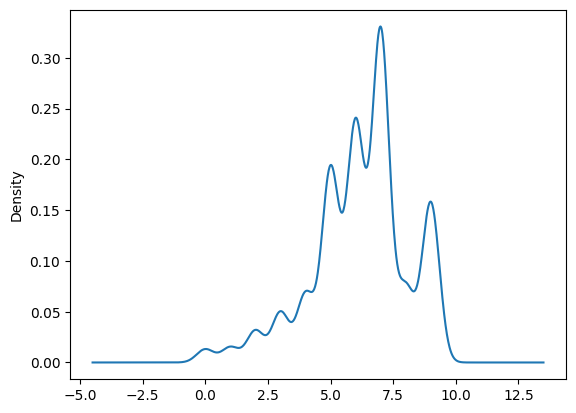

In [11]:
df['Married'].plot(kind='kde')

### Feature normalisation

When exploring the values, we can notice that the first colum "MOSTYPE" has a range that is way larger than any of the other attributes. While every other attribute is moving between the 0-10 range maximum, we have th first one moving all the way to 41. This will dispropotionally highlight this attribute in the learning algorithms. 

To prevent that, we will need to do feature normalisation. 

In [12]:
df.columns = [data_dict.get(i, {}).get('Name') for i in range (1, 87)]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.describe().loc[['min','max']])

     MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MOSHOOFD  MGODRK  MGODPR  MGODOV  \
min      1.0       1.0      1.0       1.0       1.0     0.0     0.0     0.0   
max     41.0      10.0      5.0       6.0      10.0     9.0     9.0     5.0   

     MGODGE  MRELGE  MRELSA  MRELOV  MFALLEEN  MFGEKIND  MFWEKIND  MOPLHOOG  \
min     0.0     0.0     0.0     0.0       0.0       0.0       0.0       0.0   
max     9.0     9.0     7.0     9.0       9.0       9.0       9.0       9.0   

     MOPLMIDD  MOPLLAAG  MBERHOOG  MBERZELF  MBERBOER  MBERMIDD  MBERARBG  \
min       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
max       9.0       9.0       9.0       5.0       9.0       9.0       9.0   

     MBERARBO  MSKA  MSKB1  MSKB2  MSKC  MSKD  MHHUUR  MHKOOP  MAUT1  MAUT2  \
min       0.0   0.0    0.0    0.0   0.0   0.0     0.0     0.0    0.0    0.0   
max       9.0   9.0    9.0    9.0   9.0   9.0     9.0     9.0    9.0    7.0   

     MAUT0  MZFONDS  MZPART  MINKM30  MINK3045  MINK45

In [13]:
from scipy.stats import zscore
df.apply(zscore)

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,0.999925,-0.268631,-0.843549,-1.224517,0.790073,0.283758,-0.357160,-0.061674,0.458342,-0.087854,...,-0.0773,-0.085642,-0.0633,0.718613,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,-0.263982
1,0.999925,-0.268631,-0.843549,-1.224517,0.790073,-0.697643,-0.357160,0.925672,0.458342,-1.652729,...,-0.0773,-0.085642,-0.0633,0.718613,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,-0.263982
2,-1.164030,-0.268631,0.417185,-0.002342,-0.948287,1.265159,-0.938212,0.925672,0.458342,-0.609479,...,-0.0773,-0.085642,-0.0633,0.718613,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,-0.263982
3,1.231777,-0.268631,1.677919,-1.224517,1.485417,0.283758,-0.357160,-0.061674,0.458342,0.433771,...,-0.0773,-0.085642,-0.0633,0.718613,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,-0.263982
4,-0.082052,-0.268631,-0.843549,-2.446692,-0.252943,-0.697643,0.223893,-1.049019,1.081120,-3.217605,...,-0.0773,-0.085642,-0.0633,-1.052134,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,-0.263982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5815,-1.627734,-0.268631,-0.843549,-0.002342,-1.643631,-0.697643,0.804945,-1.049019,-0.164435,-0.087854,...,-0.0773,-0.085642,-0.0633,-1.052134,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,-0.263982
5816,0.922641,-0.268631,-2.104283,-1.224517,0.790073,-0.697643,0.804945,-0.061674,-0.787213,-2.695979,...,-0.0773,-0.085642,-0.0633,0.718613,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,-0.263982
5817,0.845357,-0.268631,1.677919,1.219833,0.790073,0.283758,-0.357160,-0.061674,0.458342,-0.087854,...,-0.0773,-0.085642,-0.0633,0.718613,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,-0.263982
5818,0.690789,-0.268631,0.417185,1.219833,0.790073,-0.697643,0.804945,-1.049019,-0.164435,-0.609479,...,-0.0773,-0.085642,-0.0633,0.718613,-0.023982,-0.077813,-0.158141,-0.092297,-0.125595,3.788139


### Data dependencies and dimensionality reduction

With such a large number of attributes, it is very difficult to explore the dependencies between every column. As a proof, there is this unreadable scatter matrix for the whole dataset. It would be possible to explore dependencies for individual caes, but we would have to either pick random columns, or we could try to apply dimensionality reduction. It would be also beneficial to explore if this is possible, as we have 86 attributes. 

In [14]:
#pd.plotting.scatter_matrix(df, alpha=0.2)

In [15]:
#from matplotlib import pyplot as plt
#import seaborn as sns

#Pearson correlation heatmap
#plt.figure(figsize=(12,10))
#cor = df.corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()

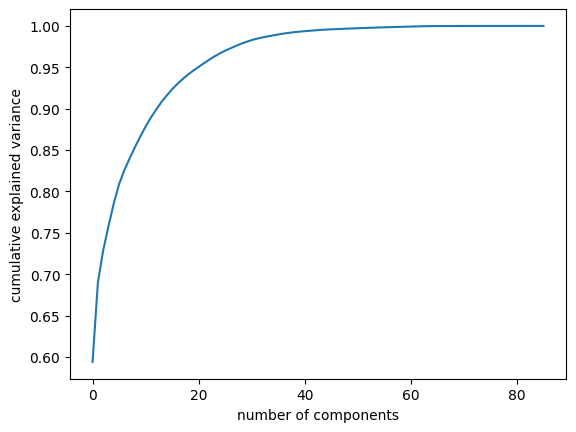

In [17]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np 

pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We can see that the first 10 componenets contain the most of variance, and we need about 40 to achieve almost 100%.
This means that with about 15 we would be able to capture above 90% of the variance. This will reduce our dimensionality from 86 to 15 which is a considerable amount. 

In [22]:
pca = PCA(15)  # project from 86 to 15 dimensions
df_pca = pca.fit_transform(df)
print(df.shape)
print(df_pca.shape)

(5219, 86)
(5219, 15)
